In [1]:
# INITIALIZATION CELL
#%load_ext autoreload
#%autoreload 2

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import math
import ipywidgets as widgets

from plot_helpers import *

import warnings
warnings.filterwarnings('ignore')
# %matplotlib qt5
%matplotlib inline
# %matplotlib widget

# pd.set_option('display.max_rows', 1000)

############## FIGURES ##############
# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-white')
# plt.style.use('ggplot')
# plt.style.use(['ggplot'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [1.65, 1.25]

def xm(x):
    return np.array([x,   1])
def ym(y):
    return np.array([1,   y])

default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
doublehh   = np.array([6.6,   2.5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

figfolder = 'plots'


EXP_CFG         = ['EXP', 'CFG'] 
EXP_CFG_REP     = EXP_CFG + ['REP']
EXP_CFG_REP_ID  = EXP_CFG_REP + ['ID']

############### Experiment selection ###################

# Obtain the list of experiments
EXP_list = [exp_folder.split('/')[-1] for exp_folder in sorted(glob.glob('%s/*' % datadir))]

# Obtain the mapping experiment -> configs
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir, exp)))] for exp in EXP_list}

# Obtain the mapping experiment/config -> reps
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir, exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

# Define all the widgets to be used
EXP_drop    = widgets.Dropdown(description='Exp:', options=EXP_list, value=EXP_list[-1], disabled=False)
EXP_mult    = widgets.SelectMultiple(description='Exp:', options=EXP_list, value=[EXP_list[-1]], disabled=False,)
CFG_drop    = widgets.Dropdown(description='Cfg:', options=['all'], value = 'all', disabled=False)
REP_drop    = widgets.Dropdown(description='Rep:', options=['all'], value = 'all', disabled=False)
LOAD_button = widgets.Button(description='Load Exp')
CONF_button = widgets.Button(description='See Config')

# Automatically default the dataset to most recently changed
recent = max([f"data/{EXP}" for EXP in EXP_list], key=os.path.getmtime).split('/')[-1]
EXP_drop.value = recent
EXP_mult.value = [recent]
print(f"last recorded dataset: {recent}")

global df_exp
global logfile
global loaded
loaded = ('','')

def on_load_button_clicked(b):
    global df_exp, logfile, loaded
    
    df_exp = create_df(EXP_drop.value, logfile)
    loaded = (EXP_drop.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
def on_conf_button_clicked(b):
    global df_exp, logfile, loaded
    
    get_config_dicts(EXP_drop.value, CFG_drop.value, REP_drop.value)
    
def on_change_exp(change):

    if change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
              
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)
LOAD_button.on_click(on_load_button_clicked)
CONF_button.on_click(on_conf_button_clicked)

def load_df(lf, select = True):
    global df_exp, logfile, loaded
    
    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(3,2)
        grid[0,0] = EXP_drop
        grid[1,0] = CFG_drop
        grid[2,0] = REP_drop
        grid[1,1] = LOAD_button
        grid[2,1] = CONF_button
        display(grid)
    
    if loaded != (EXP_drop.value, logfile):
        LOAD_button.click()
        on_change({'type':'change', 'name':'value'})
    df = df_exp
    
    if CFG_drop.value != 'all':
        df = df.query("CFG in @CFG_drop.value")

    if REP_drop.value != 'all':
        df = df.query("REP in @REP_drop.value")
    return df

def load_mult_df(lf, select = True):
    global df_exp, logfile, loaded

    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(1,2)
        grid[0,0] = EXP_mult
        grid[0,1] = CONF_button
        display(grid)
        
    df = pd.DataFrame()
    for EXP in EXP_mult.value:
        df_exp = create_df(EXP, logfile)      
        df = pd.concat([df, df_exp], ignore_index=True)
            
    loaded = (EXP_mult.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
    return df

def get_mainchains(df):
    # Process data
    mainchains = []
    for name, group in df.groupby(EXP_CFG_REP):
        group = group.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
        main_leaf = group[group['TDIFF'] == group['TDIFF'].max()]['HASH'].iloc[0]

        # Iterate from main_leaf to genesis -> mainchain
        df_mainchain = get_mainchain_df(group, main_leaf)
        mainchains += list(df_mainchain['HASH'])
    return mainchains

last recorded dataset: backup


In [3]:
df = load_mult_df('sc')

GridspecLayout(children=(SelectMultiple(description='Exp:', index=(3,), layout=Layout(grid_area='widget001'), …

New plot directory is created!
Loaded || dataframe: ('experiment_long_norec',) datafile: sc


## (cluster+color boxplot) Precision vs #Byzantine

In [1]:
%matplotlib inline
sns.set_theme()
sns.set_context("paper", font_scale=.8)
# sns.set_style("white")
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

exp_map = {
    'ShortPhy': '4) Physical',
    'shortDoS': '2) Liveness',
    'shortMal': '1) Safety',
    'shortMalDoS': '3) Combined',
    'sim_shortMal': '5) Simulation Safety'
}

# Generate the dataframe
df_clust = load_mult_df('cluster')
df_color = load_mult_df('color', False)

# Plot options
XX = 'num_byz'
YY = 'E'
yl = 'Consensus Precision'
xl = 'Number of Byzantine Robots'
fs = (4.25,4.25)

# Corrections to dataframe
df_clust = df_clust.drop_duplicates(EXP_CFG_REP+['sup_position']).query('verified==1').drop_duplicates(EXP_CFG_REP, keep='first')
df_clust['ID'] = df_clust['ID'].astype(int)
df_clust['B'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['G'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['R'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[2], axis=1).div(100000)

df_avg_red = df_color.query('IDX==0')[['B', 'G', 'R']].mean()
df_color = df_color.query('FOOD').reset_index()

# df_color = df_color.groupby(EXP_CFG_REP_ID, as_index=False).agg({'R': 'mean', 'G': 'mean', 'B': 'mean'})
df_color = df_color.groupby(EXP_CFG_REP, as_index=False).agg({'R': 'mean', 'G': 'mean', 'B': 'mean'})

df = pd.concat([df_color[['B', 'G', 'R']+EXP_CFG_REP], df_clust[['B', 'G', 'R']+EXP_CFG_REP]], keys=['Baseline', 'Ours'])
df[['_B','_G','_R']] = df_avg_red
df['E'] = df.apply(lambda row: math.sqrt((row['B']-row['_B'])**2+(row['G']-row['_G'])**2+(row['R']-row['_R'])**2), axis=1)
df.reset_index(level=0, inplace=True)
df.rename(columns={'level_0': 'Method'}, inplace=True)

#################
df = df.query('EXP != "shortR"')

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fs, sharex=True)

df_plot = df.query('Method == "Ours"')
df_plot['num_byz'] = df_plot['CFG'].str.extract('(\d+)')
df_plot['Type of Attack'] = df_plot['EXP'].map(exp_map)
df_plot = df_plot.sort_values(by=['Type of Attack','num_byz'])
sns.boxplot(data=df_plot, x=XX, y=YY, hue='Type of Attack', dodge=True, ax=ax2)

df_plot = df.query('Method == "Baseline"')
df_plot['num_byz'] = df_plot['CFG'].str.extract('(\d+)')
df_plot['Type of Attack'] = df_plot['EXP'].map(exp_map)
df_plot = df_plot.sort_values(by=['Type of Attack','num_byz'])
ax1=sns.boxplot(data=df_plot, x=XX, y=YY, hue='Type of Attack', dodge=True, ax=ax1)
ax1.legend(loc='upper center', bbox_to_anchor=(0.15, 0.9), facecolor='white', framealpha=0)
legend = ax1.legend(frameon = 1)
frame = legend.get_frame()
frame.set_linewidth(0)

# Set the labels
ax1.set(ylim=[0,100])
ax2.set(ylim=[0,100])
ax2.set(xlabel=xl, ylabel=yl)
ax1.set(xlabel='', ylabel=yl)

# ax1.set_title("Baseline")
# ax2.set_title("Our oracle")
ax1.set_title("Baseline", loc='center', y=0.85, color='black', fontweight='bold')
ax2.set_title("Our oracle", loc='center', y=0.85, color='black', fontweight='bold')

plt.gcf().tight_layout()
ax2.get_legend().remove()

# Show the plot
# plt.show()
plt.gcf().tight_layout()
fig.savefig("plots/all_errors.pdf", bbox_inches='tight')
# plt.show()


NameError: name 'sns' is not defined

## (cluster+color boxplot) Cost vs #Byzantine

In [ ]:
%matplotlib inline
sns.set_theme()
sns.set_context("paper", font_scale=.8)
# sns.set_style("white")
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

exp_map = {
    'ShortPhy': '4) Physical',
    'shortDoS': '2) Liveness',
    'shortMal': '1) Safety',
    'shortMalDoS': '3) Combined',
    'sim_shortMal': '1s) Safety',
     'sim_shortMal2': '1s) Safety'
}

# Generate the dataframe
df_clust = load_mult_df('cluster')
df_clust = df_clust.query('EXP != "shortR"')

# Corrections to dataframe
df_clust = df_clust.drop_duplicates(['sup_position']+EXP_CFG_REP, keep='first').query('verified==1')

df_clust['ID'] = df_clust['ID'].astype(int)
df_clust['B'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['G'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['R'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[2], axis=1).div(100000)

df_clust = df_clust.sort_values(by = ['EXP','CFG'])


df_clust['Type of Attack'] = df_clust['EXP'].map(exp_map)
df_clust['num_byz'] = df_clust['CFG'].str.extract('(\d+)')
df_clust['min_verified'] = df_clust['block_verified'] * 10 / 60
df_clust = df_clust.sort_values(by=['Type of Attack','num_byz'])

################
# Plot options
XX = 'num_byz'
YY = 'min_verified'
yl = 'Minutes to Consensus'
xl = 'Number of Byzantine Robots'
fs = (4.25,4.25)

# Create plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fs, sharex=True)

sns.boxplot(data=df_clust, x=XX, y=YY, hue='Type of Attack', dodge=True, ax=ax1)

ax1.legend(loc='upper center', bbox_to_anchor=(0.15, 0.9), facecolor='white', framealpha=0)
ax1.set(ylim=[0,20], xlabel=None, ylabel=yl, title='')
legend = ax1.legend(frameon = 1)
frame = legend.get_frame()
frame.set_linewidth(0)

################

df_tx = load_mult_df('tx', False)
df_tx = df_tx.query('EXP != "shortR"')
df_tx = df_tx[df_tx['MINED?']=="Yes"]
df_tx = df_tx.astype({'STATUS': 'uint', 'ID': 'uint', 'BLOCK': 'uint', 'VALUE':'float'})
# df_tx = df_tx.query('STATUS == 1')
print(f"Number of zero status TX:{len(df_tx.query('STATUS == 0'))}")

df_clust = df_clust.query('verified == 1').groupby(EXP_CFG_REP, as_index=False).agg('max')
df_tx = df_tx.merge(df_clust[EXP_CFG_REP+['block_verified']], on=EXP_CFG_REP)

df = df_tx[EXP_CFG_REP].value_counts().reset_index()
df['count'] = df['count'].astype('int')

df['Type of Attack'] = df['EXP'].map(exp_map)
df['num_byz'] = df['CFG'].str.extract('(\d+)')
df = df.sort_values(by=['Type of Attack','num_byz'])

# Plot options
XX = 'num_byz'
YY = 'count'
yl = 'Reports to Consensus'
xl = 'Number of Byzantine Robots'
 
sns.boxplot(data=df, x=XX, y=YY, hue='Type of Attack', dodge=True, ax=ax2)

# Set the labels
ax2.set(ylim=[0,60],xlabel=xl, ylabel=yl, title='')
ax2.get_legend().remove()
ax1.set_yticks(np.arange(0, 22.5, 2.5))

# Show the plot
plt.show()
plt.gcf().tight_layout()
fig.savefig("plots/all_costs.pdf", bbox_inches='tight')

# plt.savefig("plots/costs/time_and_reps.png", bbox_inches='tight', dpi=600)
# plt.show()

## (cluster+color boxplot) Precision and Cost vs Clustering Threshold

In [ ]:
%matplotlib inline
sns.set_theme()
sns.set_context("paper", font_scale=.8)
# sns.set_style("white")
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

# exp_map = {
#     'ShortPhy': '4) Physical',
#     'shortDoS': '2) Liveness',
#     'shortMal': '1) Safety',
#     'shortMalDoS': '3) Combined'
# }

# Generate the dataframe
df_clust = load_mult_df('cluster')

# Corrections to dataframe
df_clust = df_clust.drop_duplicates(['sup_position']+EXP_CFG_REP, keep='first').query('verified==1')

df_clust['ID'] = df_clust['ID'].astype(int)
df_clust['B'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['G'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['R'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[2], axis=1).div(100000)

df_clust = df_clust.sort_values(by = ['EXP','CFG'])
df_clust = df_clust.query('CFG != "5byz"')

# df_clust['Type of Attack'] = df_clust['EXP'].map(exp_map)
# df_clust['num_byz'] = df_clust['CFG'].str.extract('(\d+)')
df_clust['min_verified'] = df_clust['block_verified'] * 10 / 60
df_clust = df_clust.sort_values(by=['CFG','REP'])

###############

# df_avg_red = df_color.query('IDX==0')[['B', 'G', 'R']].mean()
# df_color = df_color.query('FOOD').reset_index()

# # df_color = df_color.groupby(EXP_CFG_REP_ID, as_index=False).agg({'R': 'mean', 'G': 'mean', 'B': 'mean'})
# df_color = df_color.groupby(EXP_CFG_REP, as_index=False).agg({'R': 'mean', 'G': 'mean', 'B': 'mean'})

# df = pd.concat([df_color[['B', 'G', 'R']+EXP_CFG_REP], df_clust[['B', 'G', 'R']+EXP_CFG_REP]], keys=['Baseline', 'Ours'])
df_clust[['_B','_G','_R']] = df_avg_red
df_clust['E'] = df_clust.apply(lambda row: math.sqrt((row['B']-row['_B'])**2+(row['G']-row['_G'])**2+(row['R']-row['_R'])**2), axis=1)

################

# Plot options
XX = 'CFG'
YY = 'E'
yl = 'Consensus Precision'
xl = 'Clustering Threshold'
fs = (4.25,2.125)

# Create plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=fs, sharex=True)
sns.boxplot(data=df_clust, x=XX, y=YY, ax=ax1)

# Set the labels
ax1.set(xlabel=None, ylabel=None, title=yl)

ax1.set_yticks(np.arange(0, 25, 5))

################

# Plot options
XX = 'CFG'
YY = 'min_verified'
yl = 'Minutes to Consensus'
xl = 'Clustering Threshold'
fs = (4.25,2.125)

sns.boxplot(data=df_clust, x=XX, y=YY, ax=ax2)

# Set the labels
ax2.set(xlabel=xl, ylabel=None, title=yl)
ax2.set_yticks(np.arange(0, 14, 3))

# ################

df_tx = load_mult_df('tx', False)
df_tx = df_tx[df_tx['MINED?']=="Yes"]
df_tx = df_tx.astype({'STATUS': 'uint', 'ID': 'uint', 'BLOCK': 'uint', 'VALUE':'float'})

print(f"Number of zero status TX:{len(df_tx.query('STATUS == 0'))}")

df_clust = df_clust.query('verified == 1').groupby(EXP_CFG_REP, as_index=False).agg('max')
df_tx = df_tx.merge(df_clust[EXP_CFG_REP+['block_verified']], on=EXP_CFG_REP)

df = df_tx[EXP_CFG_REP].value_counts().reset_index()
df['count'] = df['count'].astype('int')

# df['Type of Attack'] = df['EXP'].map(exp_map)
# df['num_byz'] = df['CFG'].str.extract('(\d+)')
df = df.sort_values(by=['CFG','REP'])

# Plot options
XX = 'CFG'
YY = 'count'
yl = 'Reports to Consensus'
xl = 'Clustering Threshold'
 
sns.boxplot(data=df, x=XX, y=YY, ax=ax3)

# Set the labels
ax3.set(xlabel=None, ylabel=None, title=yl)
ax3.set_yticks(np.arange(0, 45, 10))

# Show the plot
plt.gcf().tight_layout()


fig.savefig("plots/all_shortR.pdf", bbox_inches='tight')
# plt.show()

## (color+tx) Points and Clusters

GridspecLayout(children=(Dropdown(description='Exp:', index=3, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: experiment_long_norec datafile: color
Loaded || dataframe: experiment_long_norec datafile: cluster


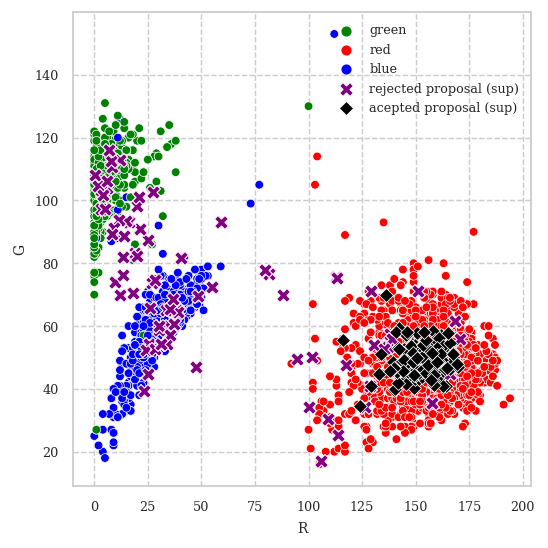

In [16]:
%matplotlib inline

def filter_bugs(df):
    df_check1 = df.query('verified==1').query("R<100")[EXP_CFG_REP].drop_duplicates()
    df_check2 = df.query("R<0 or G<0 or B<0")[EXP_CFG_REP].drop_duplicates()
    df_check = pd.concat([df_check1, df_check2], ignore_index=True).drop_duplicates()
    if not df_check.empty:
        df_check['EXP_CFG_REP'] = df_check[EXP_CFG_REP].astype(str).apply('_'.join, axis=1)
        to_drop = list(df_check['EXP_CFG_REP'])
        df = df.query("`EXP_CFG_REP` not in @to_drop")
    return df

sns.set_theme()
sns.set_context("paper", font_scale=.8)
# sns.set_style("white")
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

# Create dataframe
df_color = load_df('color')

# Create a 3D plot
fig, ax = plt.figure(figsize=(4.25,4.25)), plt.axes()

# for name, group in df.groupby('NAME'):
#     ax.scatter(group['R'], group['G'], group['B'], color=name, alpha=0.2, s=10, edgecolors='none')
palette_dict = {name: name for name in df_color['NAME'].unique()}
sns.scatterplot(data=df_color, x='R', y='G', hue='NAME', palette=palette_dict, alpha=1, edgecolors='none')

df_clust = load_df('cluster', False)
df_clust = df_clust.drop_duplicates(['sup_position']+EXP_CFG_REP, keep='first')
df_clust['B'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['G'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['R'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[2], axis=1).div(100000)

df_clust['Bc'] = df_clust.apply(lambda row: eval(row['position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['Gc'] = df_clust.apply(lambda row: eval(row['position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['Rc'] = df_clust.apply(lambda row: eval(row['position'].replace(',', ', '))[2], axis=1).div(100000)

df_clust['EXP_CFG'] = df_clust[EXP_CFG].astype(str).apply('_'.join, axis=1)
df_clust['EXP_CFG_REP'] = df_clust[EXP_CFG_REP].astype(str).apply('_'.join, axis=1)
df_clust = filter_bugs(df_clust)

dfa = df_clust.query('verified==1')
dfr = df_clust.query('verified in [2,3,4]')

sns.scatterplot(data=dfr, x='R', y='G', color='purple', alpha=1.0, marker='X', s=60, label='rejected proposal (sup)',ax=ax)
# sns.scatterplot(data=dfr, x='Rc', y='Gc', color='pink', alpha=1.0, marker='X', s=40, label='rejected proposal',ax=ax)

sns.scatterplot(data=dfa, x='R', y='G', color='black', alpha=1.0, marker='D', s=30, label='acepted proposal (sup)', ax=ax)
# sns.scatterplot(data=dfa, x='Rc', y='Gc', color='gray', alpha=1.0, marker='D', s=10, label='acepted proposal',ax=ax)

# ax.set(xlabel='R', ylabel='G', xlim=[0, 200], ylim=[0, 200])
plt.gcf().tight_layout()

ax.legend()
# fig.savefig("plots/rg_cloud.pdf", bbox_inches='tight')


## (sc timeplot) Balance vs Block

GridspecLayout(children=(SelectMultiple(description='Exp:', index=(2,), layout=Layout(grid_area='widget001'), …

Loaded || dataframe: ('experiment_long',) datafile: block
Loaded || dataframe: ('experiment_long',) datafile: cluster
Loaded || dataframe: ('experiment_long',) datafile: sc


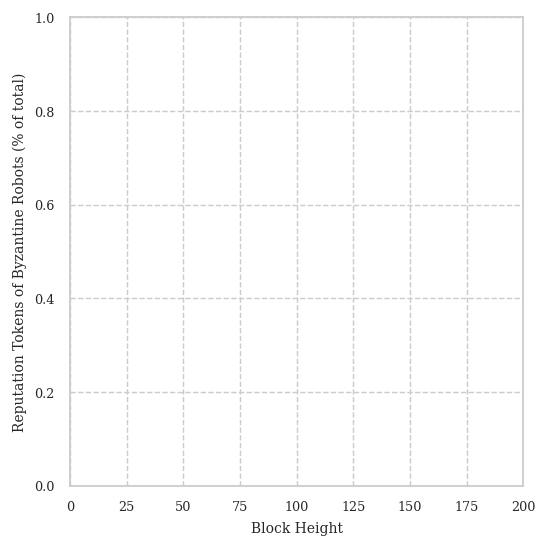

In [12]:
# %matplotlib inline
# sns.set_theme()
# sns.set_context("paper", font_scale=.8)
# sns.set_style("whitegrid", {'grid.linestyle': '--'})
# sns.axes_style("ticks")
# sns.set_style({'font.family':'serif', 'font.serif':['Latin Modern Roman']})

# exp_map = {
#     'experiment_long_safety': '1) Safety',
#     'experiment_long_liveness': '2) Liveness',
#     'experiment_long_combined': '3) Combined',
#     'experiment_long_safety_noinf': '1) Safety (I_{c}=0)',
#     'experiment_long_liveness_noinf': '2) Liveness (I_{c}=0)',
#     'experiment_long_combined_noinf': '3) Combined (I_{c}=0)',
#     'experiment_long_safety_K1': '1) Safety (K=1)',
#     'experiment_long_liveness_K1': '2) Liveness (K=1)',
#     'experiment_long_combined_K1': '3) Combined (K=1)',
# }

# # Get the mainchain
# df = load_mult_df('block')

# # Process data
# mainchains = get_mainchains(df)

# # Generate the dataframe
# df_tx = load_mult_df('cluster', False)
# df = load_mult_df('sc', False)
# df = df[df['HASH'].isin(mainchains)]
# df_tx = df_tx.drop_duplicates(subset=EXP_CFG_REP_ID)
# df = pd.merge(df, df_tx[EXP_CFG_REP_ID+['type']], on=EXP_CFG_REP_ID, how='left')

# # Group by 'REP' and 'ID', and get the last value of 'YY'
# K = 1
# df['BALANCE'] = df['BALANCE'].astype('float64')-1
# df['BALANCE'] = df['BALANCE'].clip(lower=0)
# df['#TOTAL'] = df['#ACCEPT']+df['#REJECT']
# df['Type of Attack'] = df['EXP'].map(exp_map)

# # Conversion to balance in % of total
# df = df[df['MIN_BALANCE'].notna()]
# df['MIN_BALANCE'] = pd.to_numeric(df['MIN_BALANCE'], errors='coerce')
# df.loc[df['MIN_BALANCE'] == 0, 'MIN_BALANCE'] = 53333333333333333333*3 / K
# df['SUPPLY'] = df['MIN_BALANCE']*K/(2/3)/1e18


# # df['BALANCE%'] = df['BALANCE%'].astype('float').round(1)

# # Step 1: Determine start and end points for each line
# grouped = df.groupby('EXP')['BLOCK']
# min_blocks = grouped.transform('min')  # Minimum 'BLOCK' for each line
# max_blocks = grouped.transform('max')  # Maximum 'BLOCK' for each line

# # Step 2: Normalize 'BLOCK' values to percentage scale for each line
# df['BLOCK%'] = (df['BLOCK'] - min_blocks) / (max_blocks - min_blocks) * 100

# # Plot options
# XX = '#TOTAL'
# YY = 'BALANCE%'
# yl = 'Reputation Tokens of Byzantine Robots (% of total)'
# xl = 'Time to experiment completion (%)'
# xl = 'Block Height'
# fs = (4.25,4.25)

# # Create plot
# fig, ax = plt.figure(figsize=fs), plt.axes()

# dfm = df.groupby(EXP_CFG_REP+['BLOCK', 'type','SUPPLY', '#ACCEPT', '#REJECT', '#TOTAL', 'Type of Attack'], as_index=False)['BALANCE'].agg('sum')
# dfm = dfm.sort_values(by='Type of Attack')
# dfm['SUPPLY'] = dfm['SUPPLY'].astype('int')
# dfm['BALANCE%'] = dfm['BALANCE']/dfm['SUPPLY']*100

# sns.lineplot(data=dfm.query("type=='malicious'").query("REP!='012'"), x='BLOCK', err_kws={'linewidth': 2, 'alpha': 0.6}, hue='Type of Attack', y=YY, ax=ax)# errorbar=("pi",100),

# # # Step 2: Create the legend
# # ax.legend(handles=custom_handles, labels=custom_labels)

# # Set the labels
# ax.set_xlabel(xl)
# ax.set_ylabel(yl)
# ax.set_title('') 
# # ax.set_ylim(ymin=0, ymax = 1)
# ax.set_xlim(xmin=0, xmax = 200)
# plt.gcf().tight_layout()

# # fig.savefig("plots/lr_reputation_time.pdf", bbox_inches='tight')
# plt.show()

GridspecLayout(children=(Dropdown(description='Exp:', index=3, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: experiment_long_norec datafile: block
Loaded || dataframe: experiment_long_norec datafile: cluster
Loaded || dataframe: experiment_long_norec datafile: sc


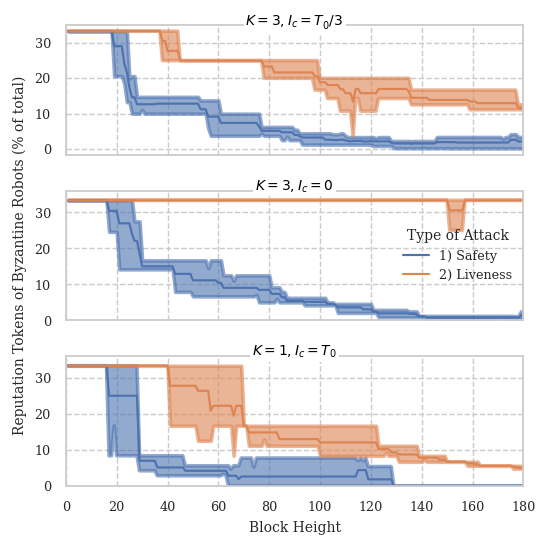

In [28]:
%matplotlib inline
sns.set_theme()
sns.set_context("paper", font_scale=.8)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Latin Modern Roman']})

exp_map = {
    EXP_drop.value+'_safety': '1) Safety',
    EXP_drop.value+'_liveness': '2) Liveness',
    EXP_drop.value+'_combined': '3) Combined',
    EXP_drop.value+'_safety_noinf': '1) Safety',
    EXP_drop.value+'_liveness_noinf': '2) Liveness',
    EXP_drop.value+'_combined_noinf': '3) Combined',
    EXP_drop.value+'_safety_K1': '1) Safety',
    EXP_drop.value+'_liveness_K1': '2) Liveness',
    EXP_drop.value+'_combined_K1': '3) Combined',
}

# Get the mainchain
df = load_df('block')

# Process data
mainchains = get_mainchains(df)

# Generate the dataframe
df_tx = load_df('cluster', False)
df = load_df('sc', False)
df = df[df['HASH'].isin(mainchains)]
df_tx = df_tx.drop_duplicates(subset=EXP_CFG_REP_ID)
df = pd.merge(df, df_tx[EXP_CFG_REP_ID+['type']], on=EXP_CFG_REP_ID, how='left')
df = get_param_df(df, 'experiment', 'MAXUNVCLUSTER', alias='K')
df['K'] = df['K'].apply(lambda x: int(x.replace("'", "")))

# Group by 'REP' and 'ID', and get the last value of 'YY'
df['BALANCE'] = df['BALANCE'].astype('float64')-1
df['BALANCE'] = df['BALANCE'].clip(lower=0)
df['BALANCE'] = df['BALANCE'].round(0)
df['#TOTAL'] = df['#ACCEPT']+df['#REJECT']
df['EXP_CFG'] = df['EXP'].astype(str) + '_' + df['CFG'].astype(str)
df['Type of Attack'] = df['EXP_CFG'].map(exp_map)

# Conversion to balance in % of total
df = df[df['MIN_BALANCE'].notna()]
df['MIN_BALANCE'] = pd.to_numeric(df['MIN_BALANCE'], errors='coerce')
df.loc[df['MIN_BALANCE'] == 0, 'MIN_BALANCE'] = 53333333333333333333*3 / df['K']
df['SUPPLY'] = df['MIN_BALANCE']*df['K']/(2/3)/1e18

# Step 1: Determine start and end points for each line
grouped = df.groupby('EXP_CFG')['BLOCK']
min_blocks = grouped.transform('min')  # Minimum 'BLOCK' for each line
max_blocks = grouped.transform('max')  # Maximum 'BLOCK' for each line

# Step 2: Normalize 'BLOCK' values to percentage scale for each line
df['BLOCK%'] = (df['BLOCK'] - min_blocks) / (max_blocks - min_blocks) * 100

# Plot options
XX = '#TOTAL'
YY = 'BALANCE%'
yl = 'Reputation Tokens of Byzantine Robots (% of total)'
xl = 'Time to experiment completion (%)'
xl = 'Block Height'

# Create plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4.25, 4.25), sharex=True)

dfm = df.groupby(EXP_CFG_REP+['BLOCK', 'type','SUPPLY', '#ACCEPT', '#REJECT', '#TOTAL', 'Type of Attack', 'EXP_CFG'], as_index=False)['BALANCE'].agg({'BALANCE':'sum','n':'count'})
dfm = dfm.sort_values(by='Type of Attack')
dfm['SUPPLY'] = dfm['SUPPLY'].astype('int')
dfm['BALANCE%'] = dfm['BALANCE']/dfm['SUPPLY']*100
dfm['EXP_CFG'] = dfm[EXP_CFG].astype(str).apply('_'.join, axis=1)
dfm['EXP_CFG_REP'] = dfm[EXP_CFG_REP].astype(str).apply('_'.join, axis=1)

dfm = dfm.query("type=='malicious'")
# dfm = dfm.query("n==4")
# dfm = filter_bugs(dfm)

CFGs = list(exp_map.keys())[0:3]
dfm1 = dfm.query("EXP_CFG in @CFGs")
sns.lineplot(data=dfm1, x='BLOCK', err_kws={'linewidth': 2, 'alpha': 0.6}, hue='Type of Attack', y=YY, ax=ax1)

CFGs = list(exp_map.keys())[3:6]
dfm2 = dfm.query("EXP_CFG in @CFGs")
sns.lineplot(data=dfm2, x='BLOCK', err_kws={'linewidth': 2, 'alpha': 0.6}, hue='Type of Attack', y=YY, ax=ax2)

CFGs = list(exp_map.keys())[6:9]
dfm3 = dfm.query("EXP_CFG in @CFGs")
sns.lineplot(data=dfm3, x='BLOCK', err_kws={'linewidth': 2, 'alpha': 0.6}, hue='Type of Attack', y=YY, ax=ax3)

# Set the labels
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel(xl)

ax1.set_ylabel('')
ax2.set_ylabel(yl)
ax3.set_ylabel('')

ax1.set_title('') 
ax2.set_title(r'$I_{c} = 0$', loc='center', y=0.92, color='black', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none', pad=1))
ax3.set_title(r'$K = 1$', loc='center', y=0.92, color='black', fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1)) 

ax1.set_xlim(xmin=0, xmax = 180)
ax2.set_xlim(xmin=0, xmax = 180)
ax3.set_xlim(xmin=0, xmax = 180)

ax2.set_ylim(ymin=0, ymax = 36)
ax2.set_ylim(ymin=0, ymax = 36)
ax3.set_ylim(ymin=0, ymax = 36)

ax1.set_title(r'$K=3, I_{c}=T_0^{}/3$', loc='center', y=0.92, color='black', fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1)) 
ax2.set_title(r'$K=3, I_{c}=0$', loc='center', y=0.92, color='black', fontweight='bold', bbox=dict(facecolor='white', edgecolor='none', pad=1))
ax3.set_title(r'$K=1, I_{c}=T_0$', loc='center', y=0.92, color='black', fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1)) 

ax1.get_legend().remove()
ax3.get_legend().remove()

plt.gcf().tight_layout()

# fig.savefig("plots/lr_reputation_time.pdf", bbox_inches='tight')
plt.show()

GridspecLayout(children=(Dropdown(description='Exp:', index=2, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: experiment_long datafile: cluster
Loaded || dataframe: experiment_long datafile: color


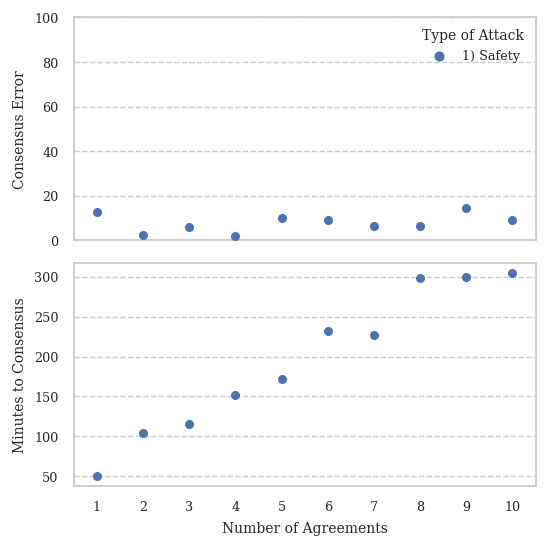

In [105]:
%matplotlib inline
sns.set_theme()
sns.set_context("paper", font_scale=.8)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Latin Modern Roman']})


df_clust = load_df('cluster')
df_clust = df_clust.drop_duplicates('position').query("verified in [1]").sort_values(by='life')

df_clust['DELTA'] = df_clust['block_verified']-df_clust['life']
df_clust['#TOTAL'] = df_clust.groupby(EXP_CFG_REP).cumcount()+1
df_clust['DELTA_MIN'] = df_clust['DELTA'] * 10 / 60
df_clust['total_credit'] = df_clust['total_credit'].astype(float)/1e18
df_clust['total_credit_food'] = df_clust['total_credit_food'].astype(float)/1e18
df_clust['FOOD%'] = df_clust['total_credit_food']/df_clust['total_credit']
df_clust['EXP_CFG'] = df_clust['EXP'].astype(str) + '_' + df_clust['CFG'].astype(str)
df_clust['EXP_CFG_REP'] = df_clust[EXP_CFG_REP].astype(str).apply('_'.join, axis=1)
df_clust['Type of Attack'] = df_clust['EXP_CFG'].map(exp_map)
df_clust = df_clust.sort_values(by=['Type of Attack'])
# df_clust = df_clust[df_clust['CFG'].str.contains('K1', na=False)]

to_drop = list(df_check['EXP_CFG_REP'])
df_clust = df_clust.query("`EXP_CFG_REP` not in @to_drop")

fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(4.25, 4.25), sharex=True)

# Plot options
XX = '#TOTAL'
YY = 'total_credit_food'
yl = "Minutes to Consensus"
xl = 'Number of Agreements'

# Create plot
sns.swarmplot(data=df_clust, x=XX, hue='Type of Attack', dodge=True, y=YY, ax=ax1)
ax1.set_xlabel(xl)
ax1.set_ylabel(yl)
# ax1.set_ylim(ymin=0, ymax = 20)
ax1.set_title('') 
ax1.get_legend().remove()

df_color = load_df('color', False)
# df_color = df_color[df_color['CFG'].str.contains('noinf', na=False)]
df_avg_red = df_color.query('IDX==0')[['B', 'G', 'R']].mean()

df_clust['B'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['G'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['R'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[2], axis=1).div(100000)
df_clust[['_B','_G','_R']] = df_avg_red
df_clust['E'] = df_clust.apply(lambda row: math.sqrt((row['B']-row['_B'])**2+(row['G']-row['_G'])**2+(row['R']-row['_R'])**2), axis=1)
df_clust = df_clust.sort_values(by=['Type of Attack'])

# Plot options
XX = '#TOTAL'
YY = 'E'
yl = "Consensus Error"
xl = ''

# Create plot
sns.swarmplot(data=df_clust, x=XX, hue='Type of Attack', dodge=True, y=YY, ax=ax2)

# Set the labels
ax2.set_xlabel(xl)
ax2.set_ylabel(yl)
ax2.set_title('') 
ax2.set_ylim(ymin=0, ymax = 100)
# ax2.set_xlim(xmin=-1, xmax = 4)

# ax2.legend(None)

plt.gcf().tight_layout()
# fig.savefig("plots/lr_cost+error.pdf", bbox_inches='tight')
plt.show()

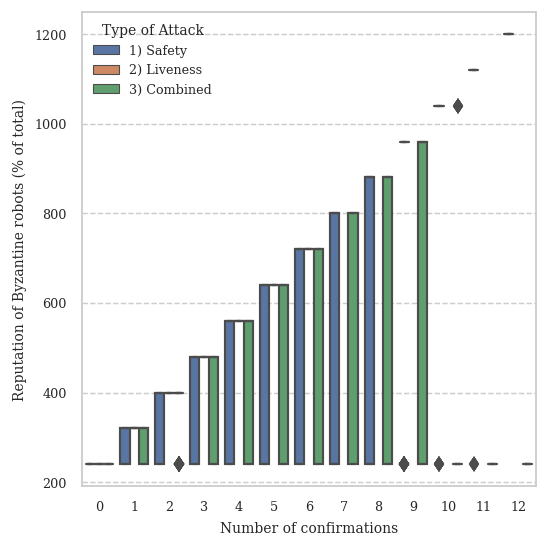

In [18]:

dfm = df.groupby(EXP_CFG_REP+['BLOCK', 'type','SUPPLY', '#ACCEPT', '#REJECT', '#TOTAL'], as_index=False)['BALANCE'].agg('sum')

# Step 1: Determine start and end points for each line
grouped = dfm.groupby('EXP')['BLOCK']
min_blocks = grouped.transform('min')  # Minimum 'BLOCK' for each line
max_blocks = grouped.transform('max')  # Maximum 'BLOCK' for each line

dfm = dfm.query("type=='malicious'")
# Step 2: Normalize 'BLOCK' values to percentage scale for each line
dfm['BLOCK%'] = (dfm['BLOCK'] - min_blocks) / (max_blocks - min_blocks) * 100
dfm['BALANCE%'] = dfm['BALANCE']/dfm['SUPPLY']
dfm['BALANCE%'] = dfm['BALANCE%']*100
# dfm['BALANCE%'] = dfm['BALANCE%'].astype('float').round(1)
dfm['Type of Attack'] = dfm['EXP'].map(exp_map)
dfm = dfm.sort_values(by=['Type of Attack'])

# Plot options
XX = '#TOTAL'
YY = 'SUPPLY'
yl = "Reputation of Byzantine robots (% of total)"
xl = 'Number of confirmations'
fs = (4.25,4.25)


# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()
sns.boxplot(data=dfm, x=XX, hue='Type of Attack', y=YY, ax=ax)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 1)
# ax.set_xlim(xmin=0, xmax = 5)
plt.gcf().tight_layout()

fig.savefig("plots/reputation_block_boxplot.pdf", bbox_inches='tight')
plt.show()

In [ ]:
%matplotlib inline
sns.set_theme()
sns.set_context("paper", font_scale=.8)
# sns.set_style("white")
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

# Generate the dataframe
df_tx = load_mult_df('tx')

print(f"Number of zero status TX:{len(df_tx.query('STATUS == 0'))}")

In [ ]:
%matplotlib inline
sns.set_theme()
sns.set_context("paper", font_scale=.8)
# sns.set_style("white")
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.axes_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

# Generate the dataframe
df_clust = load_mult_df('cluster')

# Corrections to dataframe
df_clust = df_clust.drop_duplicates(['sup_position']+EXP_CFG_REP, keep='first').query('verified==1')

df_clust['ID'] = df_clust['ID'].astype(int)
df_clust['B'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[0], axis=1).div(100000)
df_clust['G'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[1], axis=1).div(100000)
df_clust['R'] = df_clust.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[2], axis=1).div(100000)

df_clust = df_clust.sort_values(by = ['EXP','CFG'])
df_clust = df_clust.query('CFG != "5byz"')

# df_clust['Type of Attack'] = df_clust['EXP'].map(exp_map)
# df_clust['num_byz'] = df_clust['CFG'].str.extract('(\d+)')
df_clust['min_verified'] = df_clust['block_verified'] * 10 / 60
df_clust = df_clust.sort_values(by=['CFG','REP'])

###############

# df_avg_red = df_color.query('IDX==0')[['B', 'G', 'R']].mean()
# df_color = df_color.query('FOOD').reset_index()

# # df_color = df_color.groupby(EXP_CFG_REP_ID, as_index=False).agg({'R': 'mean', 'G': 'mean', 'B': 'mean'})
# df_color = df_color.groupby(EXP_CFG_REP, as_index=False).agg({'R': 'mean', 'G': 'mean', 'B': 'mean'})

# df = pd.concat([df_color[['B', 'G', 'R']+EXP_CFG_REP], df_clust[['B', 'G', 'R']+EXP_CFG_REP]], keys=['Baseline', 'Ours'])
df_clust[['_B','_G','_R']] = df_avg_red
df_clust['E'] = df_clust.apply(lambda row: math.sqrt((row['B']-row['_B'])**2+(row['G']-row['_G'])**2+(row['R']-row['_R'])**2), axis=1)

################

# Plot options
XX = 'CFG'
YY = 'E'
yl = 'Consensus Precision'
xl = 'Clustering Threshold'
fs = (4.25,2.125)

# Create plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=fs, sharex=True)
sns.boxplot(data=df_clust, x=XX, y=YY, ax=ax1)

# Set the labels
ax1.set(xlabel=None, ylabel=None, title=yl)

ax1.set_yticks(np.arange(0, 25, 5))

# ################

# # Plot options
# XX = 'CFG'
# YY = 'min_verified'
# yl = 'Minutes to Consensus'
# xl = 'Clustering Threshold'
# fs = (4.25,2.125)

# sns.boxplot(data=df_clust, x=XX, y=YY, ax=ax2)

# # Set the labels
# ax2.set(xlabel=xl, ylabel=None, title=yl)
# ax2.set_yticks(np.arange(0, 14, 3))

# # ################

# df_tx = load_mult_df('tx', False)
# df_tx = df_tx[df_tx['MINED?']=="Yes"]
# df_tx = df_tx.astype({'STATUS': 'uint', 'ID': 'uint', 'BLOCK': 'uint', 'VALUE':'float'})

# print(f"Number of zero status TX:{len(df_tx.query('STATUS == 0'))}")

# df_clust = df_clust.query('verified == 1').groupby(EXP_CFG_REP, as_index=False).agg('max')
# df_tx = df_tx.merge(df_clust[EXP_CFG_REP+['block_verified']], on=EXP_CFG_REP)

# df = df_tx[EXP_CFG_REP].value_counts().reset_index()
# df['count'] = df['count'].astype('int')

# # df['Type of Attack'] = df['EXP'].map(exp_map)
# # df['num_byz'] = df['CFG'].str.extract('(\d+)')
# df = df.sort_values(by=['CFG','REP'])

# # Plot options
# XX = 'CFG'
# YY = 'count'
# yl = 'Reports to Consensus'
# xl = 'Clustering Threshold'
 
# sns.boxplot(data=df, x=XX, y=YY, ax=ax3)

# # Set the labels
# ax3.set(xlabel=None, ylabel=None, title=yl)
# ax3.set_yticks(np.arange(0, 45, 10))

# # Show the plot
# plt.gcf().tight_layout()


# # fig.savefig("plots/all_shortR.pdf", bbox_inches='tight')
# # # plt.show()

## (tx timeplot) Transactions vs block

GridspecLayout(children=(SelectMultiple(description='Exp:', index=(1, 2, 3), layout=Layout(grid_area='widget00…

Loaded || dataframe: ('experiment_long_combined', 'experiment_long_liveness', 'experiment_long_safety') datafile: block


GridspecLayout(children=(SelectMultiple(description='Exp:', index=(1, 2, 3), layout=Layout(grid_area='widget00…

Loaded || dataframe: ('experiment_long_combined', 'experiment_long_liveness', 'experiment_long_safety') datafile: tx


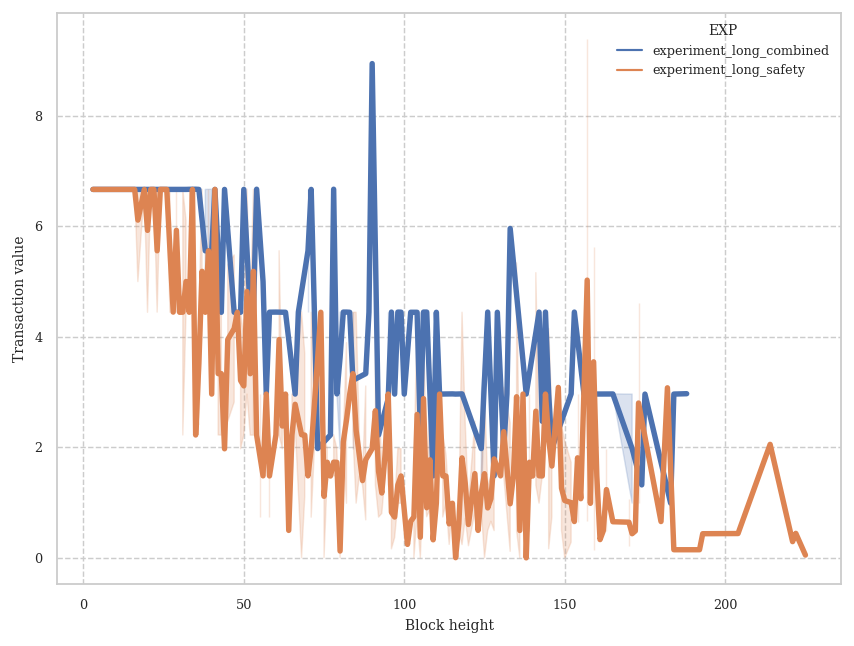

In [9]:
# Obtain the mainchains
df = load_mult_df('block')
df['BLOCK'] = df['BLOCK'].astype('int')
mainchains = get_mainchains(df)

# # Generate the dataframe
# df = df[df['HASH'].isin(mainchains)]
# df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
# # display(df.groupby(EXP_CFG_REP).agg({'BLOCK':'max'}))

# # Plot options
# XX = 'BLOCK'
# YY = 'TXS'
# yl = 'Number of txs'
# xl = 'Block height'
# fs = double

# # Create plot
# fig, ax = plt.figure(figsize=fs), plt.axes()

# df = df.set_index(XX)
# df.groupby(EXP_CFG_REP, as_index=False)[YY].cumsum().plot(ax=ax)
# for name, group in df.groupby(EXP_CFG_REP):
#     group[YY].cumsum().plot(ax=ax)

# # Set the labels
# ax.set_xlabel(xl)
# ax.set_ylabel(yl)
# ax.set_title('') 
# # plt.legend()
# plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()


# Create dataframe
df = load_mult_df('tx')

# Process data
df = df[df['MINED?']=='Yes']
df = df.astype({'STATUS': 'uint', 'ID': 'uint', 'BLOCK': 'uint', 'VALUE':'float'})

df = df[df['STATUS']==1]
df['VALUE'] = df['VALUE'].div(1e18)

# df_temp = load_df('color', False)[['ID','REP','isbyz']]
# df = df.merge(df_temp, on=['ID','REP'])
# # df['isbyz'] = df['isbyz_y']
                                          
# Plot options
XX = 'BLOCK'
YY = 'VALUE'
yl = 'Transaction value'
xl = 'Block height'
fs = double

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Plot the number of report for each robot\
# name_colors = {'faulty': 'yellow', 'malicious': 'red', 'honest':'blue'}
sns.lineplot(data=df.query("type=='malicious'"), x=XX, y=YY, ax=ax, linewidth=3, hue='EXP')
# df.set_index(XX).groupby(['REP','CFG','ID'])[YY].plot(style = '.', ax=ax)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=-0.1, ymax = 1.1)
# plt.legend()
plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

# # # Create plot
# # fig, ax = plt.figure(figsize=fs), plt.axes()

# # # Group by 'REP' and 'ID', and get the last value of 'YY'
# # name_colors = {True: 'red', False: 'blue'}
# # df = df.groupby(['ID', 'REP','isbyz'], as_index=False).agg({YY:'max'})
# # df = df[df['isbyz']==False]
# # sns.boxplot(ax=ax, data=df, x='ID', y=YY, hue='isbyz', palette=name_colors, dodge=False)

# # # # Adjust x-axis limits and ticks
# # # plt.xlim(min(df[XX]) - 1, max(df[XX]) + 1)
# # # plt.xticks(range(min(df[XX]), max(df[XX]) + 1))

# # # Set the labelsmainchains
# # ax.set_xlabel(xl)
# # ax.set_ylabel(yl)
# # ax.set_title('') 
# # ax.set_ylim(ymin=0, ymax = 30)
# # plt.legend()
# # plt.gcf().tight_layout()

# # # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# # plt.show()

## (cluster timeplot) Clusters vs Block

GridspecLayout(children=(Dropdown(description='Exp:', index=3, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: experiment_long_safety datafile: block


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Loaded || dataframe: experiment_long_safety datafile: sc


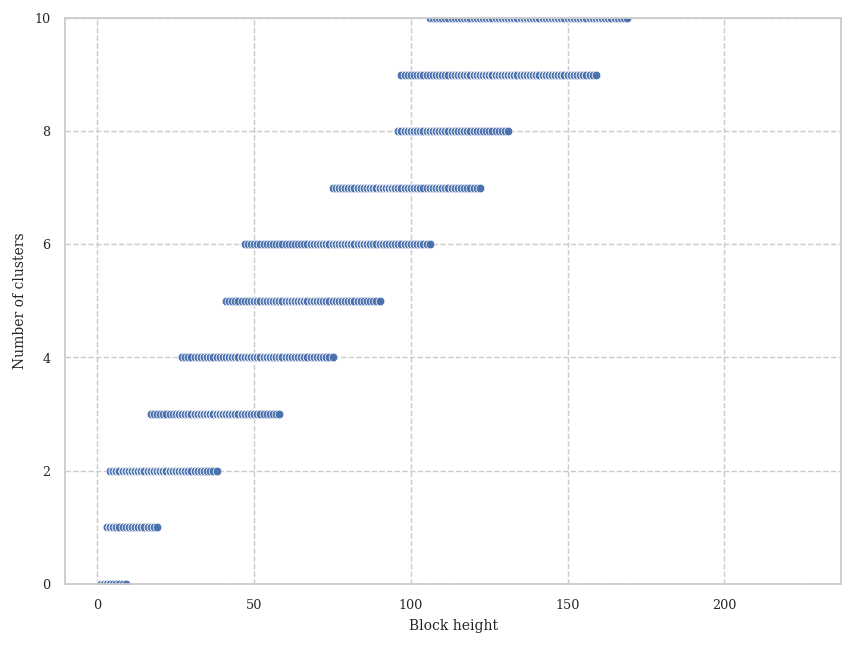

In [10]:
# Get the mainchain
df = load_df('block')
mainchains = get_mainchains(df)

# Generate the dataframe
df = load_df('sc', False)
df = df[df['HASH'].isin(mainchains)]
df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()

# Plot options
XX = 'BLOCK'
YY = '#CLUSTERS'
yl = 'Number of clusters'
xl = 'Block height'
fs = double

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

df = df.set_index(XX)

sns.scatterplot(data=df, x=XX, y=YY)#, , markers=True)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 10)
plt.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## (color + sc 3dplot) Points and Clusters 

In [ ]:
%matplotlib widget

# Create dataframe
df = load_df('color')

# Create a 3D plot
fig = plt.figure(figsize = 1.5*double)
ax = fig.add_subplot(121, projection='3d')
for name, group in df.groupby('NAME'):
    ax.scatter(group['R'], group['G'], group['B'], color=name, alpha=0.2, s=10, edgecolors='none')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
plt.gcf().tight_layout()
ax.set_xlim([0,200])
ax.set_ylim([0,150])
ax.set_zlim([0,150])

df = load_df('cluster', select = False)
df = df.drop_duplicates('sup_position')
df['B'] = df.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[0], axis=1).div(100000)
df['G'] = df.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[1], axis=1).div(100000)
df['R'] = df.apply(lambda row: eval(row['sup_position'].replace(',', ', '))[2], axis=1).div(100000)

dfa = df.query('verified==1')
ax.scatter(dfa['R'], dfa['G'], dfa['B'], color='black', alpha=1.0, marker='o', s=30, edgecolors='none', label='acepted')

dfr = df.query('verified in [2,3,4]')
ax.scatter(dfr['R'], dfr['G'], dfr['B'], color='red', alpha=1.0, marker='X', s=60, edgecolors='none', label='rejected')
ax.legend()
ax.view_init(elev=45, azim=45)

total_acepted_clusters = len(df.query('verified==1'))
print(f'False negatives: {0}/{total_acepted_clusters}')

total_rejected_clusters = len(df.query('verified==2'))
print(f'False positives: {0}/{total_rejected_clusters}')

######## SECOND PLOT #######################

df = load_df('color', select = False)
ax = fig.add_subplot(122, projection='3d')
# df_unique = df[['ID', 'isbyz']].drop_duplicates()
# print(df_unique)

df['FOOD'] = df['FOOD'].astype(bool)
# df['isfaulty']= df['isfaulty'].astype(bool)
# df['isbyz'] = df['isbyz'].astype(bool)

df_avg_red = df.query('IDX==0')[['B', 'G', 'R']].mean()
df[['_B','_G','_R']] = df_avg_red
df['E'] = df.apply(lambda row: math.sqrt((row['B']-row['_B'])**2+(row['G']-row['_G'])**2+(row['R']-row['_R'])**2), axis=1)

ax.scatter(df['_R'], df['_G'], df['_B'], alpha=1, marker='X', s=60, color='red', edgecolors='black', zorder=0, label='center')
for name, group in df.query('FOOD').query('E<40').groupby('type'):
    ax.scatter(group['R'], group['G'], group['B'], alpha=0.2, edgecolors='none', label=name)

for name, group in df.query('FOOD').query('E>40').groupby('type'):
    ax.scatter(group['R'], group['G'], group['B'], alpha=0.2, edgecolors='none', label=name)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_xlim([0,200])
ax.set_ylim([0,150])
ax.set_zlim([0,150])
ax.legend()
ax.view_init(elev=45, azim=45)
plt.gcf().tight_layout()

total_food = len(df.query('NAME=="red"'))
false_negatives = len(df.query('NAME=="red" and not FOOD'))
print(f'False negatives: {false_negatives}/{total_food}')

total_notfood = len(df.query('NAME in ["green","blue"]'))
false_positives = len(df.query('NAME in ["green","blue"] and FOOD'))
print(f'False positives: {false_positives}/{total_notfood}')



## (color boxplot) Color perception vs ID

In [ ]:
%matplotlib inline
df = load_df('color')
df_avg = df.groupby('NAME')[['R','G','B']].agg('mean')

df['ER'] = df.apply(lambda row: (row['R']-df_avg.loc[row['NAME']]['R']), axis=1)
df['EG'] = df.apply(lambda row: (row['G']-df_avg.loc[row['NAME']]['G']), axis=1)
df['EB'] = df.apply(lambda row: (row['B']-df_avg.loc[row['NAME']]['B']), axis=1)
df['E'] = df.apply(lambda row: math.sqrt(row['ER']**2+row['EG']**2+row['EB']**2), axis=1)

# Plot options
XX = 'ID'
YY = 'E'
yl = 'Color Error'
xl = 'Robot ID'
fs = double

# Corrections to dataframe
df['ID'] = df['ID'].astype(int)

# Create plot
fig, ax = plt.subplots()

sns.boxplot(df, x='ID', y=YY, hue='ID')

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 

plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

name_colors = {'red': 'red', 'blue': 'blue', 'green': 'green'}
sns.swarmplot(data=df, x='ID', y='R', hue='NAME', palette=name_colors)

ax.set_xlabel(xl)
ax.set_ylabel(yl)
plt.title('Boxplot of YY by ID and NAME')

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

## Record Color Data

In [ ]:
df_color = load_df('color')
df_color = df_color[['ID', 'NAME', 'R', 'G', 'B']]
df_color = df_color.astype({'ID': 'uint'}).sort_values(by='ID')

display(df_color)

# Group the DataFrame by 'NAME' and calculate statistics
grouped_stats = df_color.groupby('NAME').agg({
    'R': ['mean', 'std', 'min', 'max'],
    'G': ['mean', 'std', 'min', 'max'],
    'B': ['mean', 'std', 'min', 'max']
})

# Rename columns for clarity
grouped_stats.columns = ['R_mean', 'R_std', 'R_min', 'R_max',
                         'G_mean', 'G_std', 'G_min', 'G_max',
                         'B_mean', 'B_std', 'B_min', 'B_max']

# Reset the index to make 'NAME' a regular column
grouped_stats.reset_index(inplace=True)

# Now, grouped_stats contains the statistical properties of 'R', 'G', and 'B' grouped by 'NAME'
print(grouped_stats)


In [ ]:
# Debug deadlock   
df = load_mult_df('sc')
df = df.rename(columns={'#CLUSTERS': 'CLUSTERS'})
df = df.query('SPENDABLE == 7 and CLUSTERS>2')
df = df.drop_duplicates(EXP_CFG_REP)[EXP_CFG_REP+['CLUSTERS']]

# display(df.groupby(EXP_CFG_REP).agg(ID_nunique=('ID', 'nunique'), RowCount=(EXP_CFG_REP, 'size')))

pd.set_option('display.max_rows', 150)
display(df)

In [ ]:
df = load_mult_df('color')
df_color = df[['ID', 'NAME', 'R', 'G', 'B']]
df_color = df_color.astype({'ID': 'uint'}).sort_values(by='ID')

df_color['ID'] = pd.factorize(df_color['ID'])[0]+1

display(df_color)

for color, group in df_color.groupby('NAME'):
    # Store to file
    print(f"Storing color {color} to file color_data/{color}.csv")
    group[['R', 'G', 'B', 'ID']].to_csv(f"color_data/{color}.csv", index=False, header=False)